In [1]:
import sys, os
sys.path.append(os.path.join(sys.path[0].split('Documents')[0],'Documents/BecaNLP/Utils'))

import NLPUtils as nlp
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to /home/lestien/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Cargamos el dataset

,Pregunta,Intencion
0,como puedo trabajar en santander rio,102
1,pagar tarjeta visa querer reintegro,350
2,pagar tarjeta naranja sistema,132
3,no se debitó la primera cuota del plan de bien...,129
4,abonar tarjeta credito,342


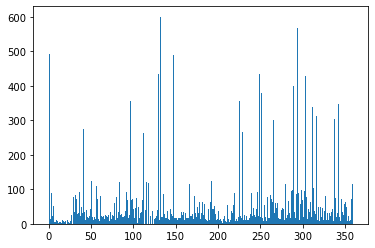

In [4]:
df = pd.read_csv('../train.csv',sep = '|')
df['Intencion'] = df.Intencion.str.findall(r'\d+').apply(lambda x: int(x[0]))
categories = set(df['Intencion'].values)
name2idx = {name:idx for idx, name in enumerate(categories)}
idx2name = {idx:name for idx, name in enumerate(categories)}
_ = plt.hist(df['Intencion'].values,bins=max(df['Intencion']))
df.head()

# Intento de uso con BERT

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Preprocesamos las muestras
query_data_train = df['Pregunta']
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_train]
print(sentences[0])

# Tokenizamos las oraciones
tokenizer = BertTokenizer.from_pretrained('beto/', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

 
MAX_LEN = 128 # Máxima longitud de las secuencias

# Paddeamos y convertimos en idx:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

[CLS] como puedo trabajar en santander rio [SEP]
Tokenize the first sentence:
['[CLS]', 'como', 'puedo', 'trabajar', 'en', 'santa', '##n', '##der', 'rio', '[SEP]']


array([    4,  1184,  1769,  3460,  1036, 18244, 30935,  1295, 25355,
           5,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

BERT’s clever language modeling task masks 15% of words in the input and asks the model to predict the missing word. To make BERT better at handling relationships between multiple sentences, the pre-training process also included an additional task: given two sentences (A and B), is B likely to be the sentence that follows A? Therefore we need to tell BERT what task we are solving by using the concept of attention mask and segment mask. In our case, all words in a query will be predicted and we do not have multiple sentences per query. We define the mask below.

In [7]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

Dividimos en train y dev tanto las muestras y sus labels como las máscaras de atención

In [8]:
labels = np.array([name2idx[name] for name in df['Intencion'].values])

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 64

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [9]:
model = BertForSequenceClassification.from_pretrained("beto/", num_labels=int(np.unique(labels).size))
USE_GPU = True
device = torch.device('cuda:1') if torch.cuda.is_available() and USE_GPU else torch.device('cpu')
model = model.to(device)

OSError: Error no file named ['pytorch_model.bin', 'tf_model.h5', 'model.ckpt.index'] found in directory beto/ or `from_tf` set to False

As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. Training the classifier is relatively inexpensive. The bottom layers have already great English words representation, and we only really need to train the top layer, with a bit of tweaking going on in the lower levels to accommodate our task. This is a variant of transfer learning.

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 4.835009839425239


Epoch:  25%|██▌       | 1/4 [02:53<08:39, 173.08s/it]

Validation Accuracy: 0.061577690972222224
Train loss: 4.762977288384319


Epoch:  50%|█████     | 2/4 [05:47<05:46, 173.42s/it]

Validation Accuracy: 0.056694878472222224
Train loss: 4.690191201523421


Epoch:  75%|███████▌  | 3/4 [08:41<02:53, 173.70s/it]

Validation Accuracy: 0.06828703703703703
Train loss: 4.638469020385203


Epoch: 100%|██████████| 4/4 [11:36<00:00, 174.03s/it]

Validation Accuracy: 0.06877531828703703


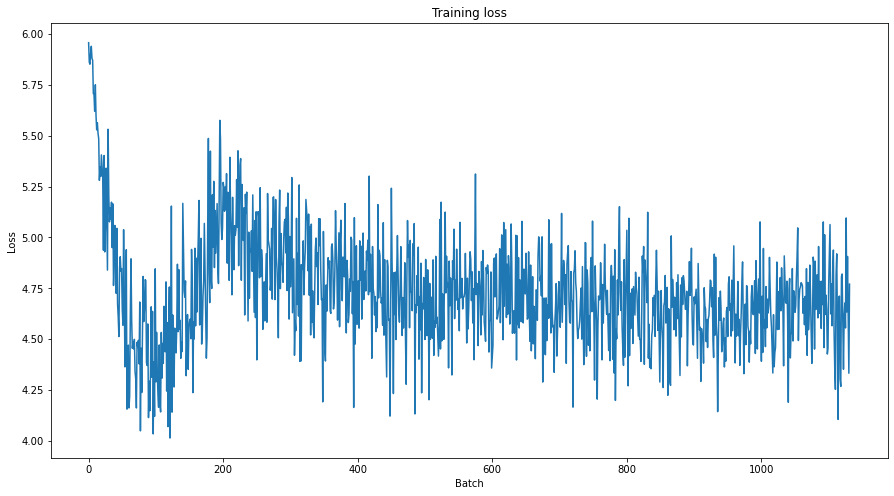

In [8]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

lr = 2e-4
max_grad_norm = 1.0
num_training_steps = 1000
num_warmup_steps = 100
warmup_proportion = float(num_warmup_steps) / float(num_training_steps)  # 0.1
optimizer = AdamW(optimizer_grouped_parameters,lr=lr,correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps, 
                                            num_training_steps=num_training_steps)  # PyTorch scheduler

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
train_loss_set = [] # Store our loss and accuracy for plotting
epochs = 4 # Number of training epochs 

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
    
    ## TRAINING:
    # Set our model to training mode
    model.train()  
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss, _ = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
        optimizer.step()
        scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    ## VALIDATION:
    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
        # Move logits and labels to CPU
        logits = logits[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# Evaluación en test